Epoch 1/10
220/220 [==============================] - 16s 52ms/step - loss: 0.0103
Epoch 2/10
220/220 [==============================] - 12s 53ms/step - loss: 0.0075
Epoch 3/10
220/220 [==============================] - 12s 56ms/step - loss: 0.0061
Epoch 4/10
220/220 [==============================] - 10s 46ms/step - loss: 0.0055
Epoch 5/10
220/220 [==============================] - 10s 46ms/step - loss: 0.0049
Epoch 6/10
220/220 [==============================] - 10s 45ms/step - loss: 0.0045
Epoch 7/10
220/220 [==============================] - 10s 47ms/step - loss: 0.0042
Epoch 8/10
220/220 [==============================] - 11s 48ms/step - loss: 0.0040
Epoch 9/10
220/220 [==============================] - 11s 48ms/step - loss: 0.0040
Epoch 10/10
109/109 [==============================] - 2s 10ms/step


AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

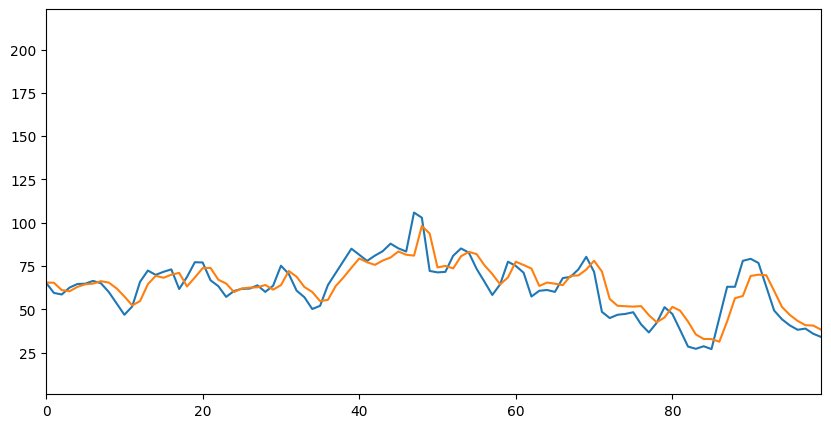

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Load the dataset
df = pd.read_csv('kurla_cleaned.csv')
df=df.drop(df[['Date']],axis=1)
# Select the feature to be predicted
target_col = 'PM2.5'

# Normalize the dataset
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[target_col].values.reshape(-1, 1))

# Split the dataset into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Create the input and output sequences for the LSTM model
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data)-lookback-1):
        X.append(data[i:(i+lookback), 0])
        y.append(data[(i+lookback), 0])
    return np.array(X), np.array(y)

lookback = 24 # number of hours to look back
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)

# Reshape the input sequences for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64)

# Predict the PM2.5 levels for the test set
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the predicted vs actual PM2.5 levels
import matplotlib.pyplot as plt

# plt.plot(y_test, label='Actual')
# plt.plot(y_pred, label='Predicted')

# plt.legend()
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(y_test[1000:1300], label='Actual')
ax.plot(y_pred[1000:1300], label='Predicted')
ax.set_xlim(0, 99)  # set x-axis limit to show only the first 100 data points
ax.xlabel('Hours')
ax.ylabel('PM2.5 levels')
ax.legend()
ax.show()
